# Simulation of 2,3-butanediol production in S. elongatus


## Supplementary dataset 

## "Predicting the metabolic capabilities of Synechococcus elongatus PCC 7942 adapted to different light regimes"

### Broddrick, et. al. 


### Jared Broddrick
### 10/10/18

In [1]:
import pandas as pd
import numpy as np
import csv
import cobra
import xlrd
import re
import math as m
from cobra.core.metabolite import elements_and_molecular_weights
elements_and_molecular_weights['R']=0.0
elements_and_molecular_weights['Z']=0.0
import copy
import matplotlib.pyplot as plt
%matplotlib inline


### 1) Load in the model

In [2]:
# Load in the model
model = cobra.io.load_json_model('iJB792.json')

### 1.1) Add 23BD production pathway

In [3]:
######################### Glucose uptake #############################
from cobra import Metabolite
## Exchange
rxn = model.reactions.EX_gln__L_e.copy()
rxn.id = 'EX_glc__D_e'
rxn.name = 'Modeling: exchange reaction (glc__D_e)'
rxn.lower_bound = 0.
rxn.upper_bound = 0.
m1 = model.metabolites.glc__D_c.copy()
m1.id = 'glc__D_e'
m2 = model.metabolites.gln__L_e
rxn.add_metabolites({m1:1.,
                   m2:1.})
model.add_reaction(rxn)


### Transporter
rxn = model.reactions.GLNtex.copy()
rxn.id = 'GLCtex'
rxn.name = 'Glucose transport via diffusion (extracellular to periplasm)'
m1 = model.metabolites.glc__D_e
m2 = model.metabolites.glc__D_c.copy()
m2.id = 'glc__D_p'
m3 = model.metabolites.gln__L_p
m4 = model.metabolites.gln__L_e
rxn.add_metabolites({m1:-1.,
                   m2:1.,
                   m3:-1.,
                   m4:1.})
model.add_reaction(rxn)

##
rxn = model.reactions.NAt3ipp.copy()
rxn.id = 'GLCt2pp'
rxn.name = 'Glucose transport via proton symport (periplasm)'
m1 = model.metabolites.glc__D_p
m2 = model.metabolites.glc__D_c
m3 = model.metabolites.na1_p
m4 = model.metabolites.na1_c
rxn.add_metabolites({m1:-1.,
                   m2:1.,
                   m3:-1.,
                   m4:1.})
model.add_reaction(rxn)
model.repair()


### 23BD pathway

m1 = Metabolite(
    'actn__R_c',
    formula='C4H8O2',
    name='R-acetonin',
    compartment='c')
rxn = model.reactions.OXADC.copy()
rxn.id = 'ACLDC'
rxn.name = '2-acetolactate decarboxylase'
rxn.gene_reaction_rule =''
m3 = model.metabolites.oxa_c
m4 = model.metabolites.for_c
m5 = model.metabolites.alac__S_c
rxn.add_metabolites({m1:1.,
                    m3:1.,
                    m4:-1.,
                    m5:-1.})
model.add_reaction(rxn)
model.repair()

################################

m1 = Metabolite(
    'btd_RR_c',
    formula='C4H10O2',
    name='R,R-2,3-butanediol',
    compartment='c')
rxn = model.reactions.LDH_D.copy()
rxn.id = 'BTDD_RR'
rxn.name = 'R,R-butanediol dehydrogenase'
rxn.gene_reaction_rule =''
m3 = model.metabolites.lac__D_c
m4 = model.metabolites.pyr_c
m5 = model.metabolites.actn__R_c
rxn.add_metabolites({m1:-1.,
                    m3:1.,
                    m4:-1.,
                    m5:1.})
model.add_reaction(rxn)
model.repair()

######################################

reaction = model.reactions.DM_pho_loss_c.copy()
reaction.id = 'DM_btd_RR_c'
reaction.name = 'Demand Reaction: 2,3-butanediol'
m1 = model.metabolites.pho_loss_c
m2 = model.metabolites.get_by_id('btd_RR_c')
reaction.add_metabolites({m1:1,
                         m2:-1})
reaction.lower_bound = 0.
model.add_reaction(reaction)
model.repair()


### 2) Constrain the media components
##### Media: BG-11



In [4]:
# Load the media composition
EX_rxns = [m.id for m in model.reactions if m.id[0:3]=='EX_']
for r in EX_rxns:
    model.reactions.get_by_id(r).upper_bound = 1000.
    model.reactions.get_by_id(r).lower_bound = 0.    


EXrxn = ['EX_h2o_e','EX_o2_e','EX_co2_e','EX_cobalt2_e','EX_zn2_e','EX_so4_e','EX_ca2_e','EX_nh4_e','EX_mn2_e','EX_hco3_e','EX_mg2_e','EX_cu2_e','EX_k_e','EX_no3_e','EX_fe3_e','EX_mobd_e','EX_na1_e','EX_h_e','EX_pi_e']
EXlb = [-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000]
for i in range(len(EXrxn)):
    rx = EXrxn[i]
    model.reactions.get_by_id(rx).lower_bound = EXlb[i]

### 3) Condition specific pigment values


In [5]:
# ## Edit pigments

# # High Light:
# pigment_mass = {'hpdcn_c' :0.510,
#                 'calxan_c' :0.153,
#                 'caro_c' :0.102,
#                 'nstxan_c' :0.051,
#                 'phycy_c' :0.223,
#                 'cholphya_c' :0.510,
#                 'zeax_c' :0.204}


#Low Light: 
pigment_mass = {'hpdcn_c' :0.473,
                'calxan_c' :0.142,
                'caro_c' :0.095,
                'nstxan_c' :0.047,
                'phycy_c' :0.332,
                'cholphya_c' :0.473,
                'zeax_c' :0.189}

pigment_data = dict()

for m,s in pigment_mass.iteritems():
    met_obj = model.metabolites.get_by_id(m)
    pigment_data[met_obj]=s
    
r = model.reactions.BM_PIGMENTS

new_stoich = pigment_data

# you now have a dictionary of new stoichs for your model
for m,s in r.metabolites.iteritems():
    stoich = s*-1
    temp_dict = {m:stoich}
    r.add_metabolites(temp_dict)
r.add_metabolites(new_stoich)

# Then get the total to equal 1 mg biomass DW
total = 0
for m,s in r.metabolites.iteritems():
    gfw = model.metabolites.get_by_id(m.id).formula_weight
    mass = gfw*s*-1
    total = total+mass
correction = total/1000 # this will get it to 1000 ug total mass

# Then adjust the stoichiometry as appropriate
for m,s in r.metabolites.iteritems(): # now change the stoich
    to_add = s/correction-s
    r.add_metabolites({m:to_add})

# Finally build the biomass_c metabolite
    imbal = r.check_mass_balance()
    if 'charge' in imbal.keys():
        met_charge = imbal['charge']*-1
        del imbal['charge']
    met_mass = 0
    formula_string = ''
    for e,v in imbal.iteritems():
        if v > 1e-10 or v < -1e-10:
            mass = elements_and_molecular_weights[e]
            met_mass = met_mass+(mass*-1*v)
            form_str = e+str(-1*v)
            formula_string = formula_string + form_str

met = model.metabolites.bm_pigm_c
met.formula = formula_string
met.charge = met_charge
r.add_metabolites({met:1})

model.repair()

### 4) Condition specific biomass objective function

In [6]:
# #HL BOF

# bof_ratios = {'bm_carbs_c':0.10,
#             'bm_dna_c':0.007,
#             'bm_memlip_c':0.20,
#             'bm_pigm_c':0.021,
#             'bm_cofactors_c':0.012,
#             'bm_pro_c':0.40,
#             'bm_cw_c':0.070,
#             'bm_rna_c':0.15}

# # LL BOF
bof_ratios = {'bm_carbs_c':0.10,
            'bm_dna_c':0.007,
            'bm_memlip_c':0.20,
            'bm_pigm_c':0.021,
            'bm_cofactors_c':0.012,
            'bm_pro_c':0.45,
            'bm_cw_c':0.070,
            'bm_rna_c':0.15}

bof_data = dict()

for bofcmp,percent in bof_ratios.iteritems():
    met_obj = model.metabolites.get_by_id(bofcmp)
    bof_data[met_obj]=percent*-1
    
# copy the bof reaction
r = model.reactions.BOF
new_stoich = bof_data

# you now have a dictionary of new stoichs for your model
for m,s in r.metabolites.iteritems():
    stoich = s*-1
    temp_dict = {m:stoich}
    r.add_metabolites(temp_dict)
r.add_metabolites(new_stoich)

# Then get the total to equal 1 mg biomass DW
total = 0
for m,s in r.metabolites.iteritems():
    gfw = model.metabolites.get_by_id(m.id).formula_weight
    mass = gfw*s*-1
    total = total+mass
correction = total/1000 # this will get it to 1000 ug total mass

# Then adjust the stoichiometry as appropriate
for m,s in r.metabolites.iteritems(): # now change the stoich
    to_add = s/correction-s
    r.add_metabolites({m:to_add})

met1 = model.metabolites.atp_c
met2 = model.metabolites.h2o_c
met3 = model.metabolites.adp_c
met4 = model.metabolites.h_c
met5 = model.metabolites.pi_c

r.add_metabolites({met1:-30,
                  met2:-30,
                  met3:30,
                  met4:30,
                  met5:30})


model.repair()

total_imbalance = 0.
imbalance = model.reactions.BOF.check_mass_balance()
for eles,vals in imbalance.iteritems():
    if eles != 'charge':
        gfw = elements_and_molecular_weights[eles]
        tmp_mass = gfw*vals
        total_imbalance = total_imbalance+tmp_mass

cobra/core/metabolite.py:102 UserWarning: 66.6064 is not an integer (in formula H66.6064C36.8088O30.674R4.2584)
cobra/core/metabolite.py:102 UserWarning: 36.8088 is not an integer (in formula H66.6064C36.8088O30.674R4.2584)
cobra/core/metabolite.py:102 UserWarning: 30.674 is not an integer (in formula H66.6064C36.8088O30.674R4.2584)
cobra/core/metabolite.py:102 UserWarning: 4.2584 is not an integer (in formula H66.6064C36.8088O30.674R4.2584)
cobra/core/metabolite.py:102 UserWarning: 33.59035 is not an integer (in formula H33.59035P3.1168C29.60979O21.81767N11.77262R-1.0)
cobra/core/metabolite.py:102 UserWarning: 3.1168 is not an integer (in formula H33.59035P3.1168C29.60979O21.81767N11.77262R-1.0)
cobra/core/metabolite.py:102 UserWarning: 29.60979 is not an integer (in formula H33.59035P3.1168C29.60979O21.81767N11.77262R-1.0)
cobra/core/metabolite.py:102 UserWarning: 21.81767 is not an integer (in formula H33.59035P3.1168C29.60979O21.81767N11.77262R-1.0)
cobra/core/metabolite.py:102 Use

### 5) Global Constraints

#### Reactions to turn off:

1) CYOOum and LDH_D carries no flux


In [7]:
model.reactions.LDH_D.upper_bound = 0.

rxn =  ['CYOOum']
for i in range(len(rxn)):
    rx = rxn[i]
    model.reactions.get_by_id(rx).lower_bound = 0
    model.reactions.get_by_id(rx).upper_bound = 0
    
######################
# Non-photochemical loss of photons
reaction = model.reactions.DM_pho_loss_c.copy()
reaction.id = 'DM_chla_qy2_c'
reaction.name = 'Demand Reaction: excitation energy at PSII'
m1 = model.metabolites.pho_loss_c
m2 = model.metabolites.get_by_id('chla_qy2*_c')
m3 = model.metabolites.cholphya_c

reaction.add_metabolites({m1:1,
                         m2:-1,
                          m3:1.})
reaction.upper_bound = 0.
print reaction
model.add_reaction(reaction)
model.repair()
    
# Non-photochemical loss of photons
reaction = model.reactions.DM_pho_loss_c.copy()
reaction.id = 'DM_chla_qy1_c'
reaction.name = 'Demand Reaction: excitation energy at PSI'
m1 = model.metabolites.pho_loss_c
m2 = model.metabolites.get_by_id('chla_qy1*_c')

reaction.add_metabolites({m1:1,
                         m2:-1,
                          m3:1.})
reaction.upper_bound = 0.
print reaction
model.add_reaction(reaction)
model.repair()


DM_chla_qy2_c: chla_qy2*_c --> cholphya_c
DM_chla_qy1_c: chla_qy1*_c --> cholphya_c


### 6) Photon constraints

Read in the absorbance coefficients in units of cm2/cell

Select one of the following

LL : low light mean values 

LL_UB: low light mean +1 SD

LL_LB: low light mean -1 SD

HL : low light mean values 

HL_UB: low light mean +1 SD

HL_LB: low light mean -1 SD

In [8]:
# Photon constraints
# read in the a* values NOTE** Units are cm2/cell
a_star = pd.read_csv('se_a_star.csv',index_col=0,header=0)
a_star = a_star['LL_UB'] # Choose HL or LL
# read in the cool white lamp spectral density
rel = pd.read_csv('fluor_lamp.csv',header=0)


### 5) Define simulation parameters

# Units time = minutes, mass = mg, amount = umol

#### Time interval: 20 min 

#### Number of slices for the path length light attenuation: 50

#### Culture dimensions: 5 cm deep, 375 mL total volume

#### Surface area = 80 cm2

In [9]:
# Reduce the penalty of PSII charge recombination to 0.5% of the flux results in D1 damage

rxn = model.reactions.PSIICRum
m1 = model.metabolites.ps2d1_um
m2 = model.metabolites.get_by_id('ps2d1*_um')

rxn.add_metabolites({m1:0.005,
                    m2:-0.005})
print rxn


PSIICRum: p680*_um + 0.005 ps2d1_um --> p680_um + 0.005 ps2d1*_um


In [10]:
# Initialize all initial conditions, output variables and storage pools
# mgCell = 0.8/1e9 # mgDW per cell <-- HL 1.0 +/- 0.2
mgCell = 1.1/1e9 # mgDW per cell <-- LL 1.3 +/- 0.2

iDW = 27.5 # initial culture biomass; approximately 1 g/L

## Glucose uptake rate
glc_uptake = 4.5e-3 #### glucose uptake in umol/mgDW*min 

### Cell count is mgDW/mgCEll

xsec = 70. #culture cross sectional area in cm2
slices = 50  # number of slices
vol = 100./slices      # percent volume of each vertical slice
rv = vol/100. # fractional volume of each slice


# Changing the bounds to umol instead of mmol

for r in model.reactions:
    r.lower_bound = r.lower_bound*1000.
    r.upper_bound = r.upper_bound*1000.

In [11]:
## Initialize all the parameters and data collectors for the simulation

# Simulate biomass accumulation
time_interval = 20

gDW = iDW
cells = (gDW/mgCell)

#______________________________________________Tnitialize variables to collect output data___________________________________
# Initialize an unused photon count
photon_usage = pd.DataFrame(data=[0,0],index = ['Delivered','Absorbed'],columns=['0'])

biomass = pd.DataFrame(data=[gDW,cells,0,0],index = ['Biomass','Cells','23BD','glucose'],columns=['0']) # add it up at the end of each simulation

# Initialize an O2 evolution rate tracker
o2_check = pd.DataFrame(data=[0],index = ['Max oxygen evolution'],columns=['0'])



In [12]:
# Simulate over the time interval
for t in range(time_interval,4320+time_interval,time_interval): #One simulation every hour from t=0 to t=9 days (216 hrs)
    import math as m
    
    interval_bm = 0 #initializes the total biomass
    photon_count = 0
    atten = np.zeros(len(a_star)) #captures light attenuation

    tmp_o2_evo = 0

    gDW = biomass[str(t-time_interval)]['Biomass'] #mg DW
    IBD_val = biomass[str(t-time_interval)]['23BD'] #mg DW
    glc_val = biomass[str(t-time_interval)]['glucose'] #mg DW
    cells = (gDW/mgCell)
    
#O2 rate equation High Light              <----- LL vs HL
    # input: umol photons cell-1 s-1
    # Output: umol O2 cell-1 s-1
    #HL
#     Ps = 1.10e-12 # umol O2 cell-1 s-1
#     alpha = 2.20e-2
#     beta = 6.0e-4
#     resp = 1.14E-13
    
#     #     ##HL UB
#     Ps = 1.17e-12 # umol O2 cell-1 s-1
#     alpha = 2.15e-2
#     beta = 4.4e-4
#     resp = 0.938E-13
    
#     #     ##HL LB
#     Ps = 1.00e-12 # umol O2 cell-1 s-1
#     alpha = 2.26e-2
#     beta = 7.8e-4
#     resp = 1.35E-13
    
####################################################
    
#     # LL
#     Ps = 1.44e-12 # umol O2 cell-1 s-1
#     alpha = 4.27e-2
#     beta = 3.5e-3
#     resp = 5.36E-14
    
    # LL UB
    Ps = 1.65e-12 # umol O2 cell-1 s-1
    alpha = 4.62e-2
    beta = 4.1e-3
    resp = 4.71E-14
    
#     # LL LB
#     Ps = 1.24e-12 # umol O2 cell-1 s-1
#     alpha = 3.95e-2
#     beta = 2.82e-3
#     resp = 6.02E-14
    
    
    # Calculate photons and O2 uptake
#     irrad =  600. #uE 
    irrad = 30.                            # <----- LL vs HL

    # Photon_flux is the initial amount of light delivered to the culture at each wavelength from 400-700 nm
    photon_flux = (rel['rel_height'].values)*irrad*xsec/10000*time_interval*60. #umol/(m2*s) * cm2 * 1m2/10000cm2 * 60s/min * min = umol photons/time interval
    total_photons = sum(photon_flux)
    photon_usage[str(t)]=[total_photons,0]

    ngam = resp*60.*time_interval*cells
    model.reactions.NGAM.lower_bound = ngam

    total_absorbed = 0.
    ti_o2 = 0.
    
    
    # Variable to collect the photons absorbed
    lmba_placeholder = np.zeros(15) # one bin per photon bin  

    interval_bins =  pd.DataFrame(data=lmba_placeholder,index =['410','430','450','470','490','510',
                                                            '530','550','570','590','610','630','650',
                                                                '670','690'], columns=['Photons'])

    for s in range(slices):

        # First get delivered photons
        delivered_photons = photon_flux

        # Variable to collect the photons absorbed
        slice_abs = 0.
        slice_o2 = 0. 
        for nm in range(len(photon_flux)):
            # Assign the bin
            a_nm = 400+nm
            if a_nm in range(400,420):
                nm_bin = '410'
            if a_nm in range(420,440):
                nm_bin = '430'
            if a_nm in range(440,460):
                nm_bin = '450'
            if a_nm in range(460,480):
                nm_bin = '470'
            if a_nm in range(480,500):
                nm_bin = '490'
            if a_nm in range(500,520):
                nm_bin = '510'
            if a_nm in range(520,540):
                nm_bin = '530'
            if a_nm in range(540,560):
                nm_bin = '550'
            if a_nm in range(560,580):
                nm_bin = '570'
            if a_nm in range(580,600):
                nm_bin = '590'
            if a_nm in range(600,620):
                nm_bin = '610'
            if a_nm in range(620,640):
                nm_bin = '630'
            if a_nm in range(640,660):
                nm_bin = '650'
            if a_nm in range(660,680):
                nm_bin = '670'
            if a_nm in range(680,701):
                nm_bin = '690'

            # calculate the absorbed photons
            abs_coeff = a_star[400+nm]              # a* value for the given nm (cm2/cell)
            nm_delivered = delivered_photons[nm]    # incident photon flux at this nm at this slice (umol_photon/time_interval)
            nm_abs = nm_delivered*abs_coeff*(cells*rv)/xsec # photons absorbed at this nm at this slice(umol/TI * cm2/cell * cell *cm-2)

            if nm_abs > nm_delivered:
                nm_abs = nm_delivered
            
            # Update the photon_flux variable at this wavelength
            new_delivered = nm_delivered - nm_abs
            if new_delivered >= 0:
                photon_flux[nm] = new_delivered
            else:
                photon_flux[nm] = 0.

            # Append the running photon absorption
            slice_abs = slice_abs + nm_abs

            # Append the appropriate bin
            interval_bins.at[nm_bin,'Photons'] = interval_bins['Photons'][nm_bin] + nm_abs


        # Update the variables that will constrain photon flux
        total_absorbed = total_absorbed+slice_abs

        conv_abs = slice_abs/time_interval/60./(cells*rv) # converts abs to O2 evo curve units  umol/TI * TI/min * min/s * 1/cells => umol/(mgchla*s)
        slice_o2 = (Ps*(1-m.exp(-1*alpha*conv_abs/Ps))*(m.exp(-1*beta*conv_abs/Ps)))-resp #umol O2 cell-1 s-1

        ti_o2 = ti_o2+(slice_o2*(rv*cells)*60.*time_interval) #umol O2 cell-1 s-1 * cells * s/min * min/TI = umol O2/TI

    o2_check[str(t)]=ti_o2

    o2evo = ti_o2
    model.reactions.EX_o2_e.upper_bound = o2evo
    model.reactions.EX_o2_e.lower_bound = -1e6
    photon_usage[str(t)]['Absorbed']=total_absorbed

    # ________________________________Time point constraints_________________________________________#

    #Photon constraints
    
    ex_photon = ['EX_photon410_e', 'EX_photon430_e', 'EX_photon450_e', 'EX_photon470_e', 'EX_photon490_e',
                 'EX_photon510_e', 'EX_photon530_e', 'EX_photon550_e', 'EX_photon570_e', 'EX_photon590_e', 
                 'EX_photon610_e', 'EX_photon630_e', 'EX_photon650_e', 'EX_photon670_e', 'EX_photon690_e']

    for bin_ids in interval_bins.index:
        exch_rxn = [rxn_item for rxn_item in ex_photon if bin_ids in rxn_item]
        model.reactions.get_by_id(exch_rxn[0]).lower_bound = -1*interval_bins[interval_bins.index==bin_ids]['Photons'].values[0]
        model.reactions.get_by_id(exch_rxn[0]).upper_bound = -0.9999*interval_bins[interval_bins.index==bin_ids]['Photons'].values[0]

    model.reactions.DM_pho_loss_c.upper_bound = 1e6 # allows loss of photons upstream of PSI/PSII based on energy transport efficiencies
    ### Optional - allows dissipation of excess photons beyond energy transport efficiencies
    # If set to 0: constrained model- requires intracellular AET to consume excess excitation energy
    # To run unconstrained model simulations (calculate the minimum e- for growth/maintenance) set to 10000.
    model.reactions.DM_chla_qy1_c.upper_bound = 0.
    model.reactions.DM_chla_qy2_c.upper_bound = 0.
    
    ## Glucose uptake rate
    glc_ub = glc_uptake*time_interval*gDW # umol/mgDW*min * mgDW * min/TI = umol/TI
    model.reactions.EX_glc__D_e.upper_bound = glc_ub

    ###__________________________________OBJECTIVE FUNCTION____________________________________###

    model.objective = 'BOF'
    solution = model.optimize()

    # Set minimum biomass 
    obj_rxn = model.reactions.BOF
    frac_BOF = 0.20
   
    model.reactions.BOF.lower_bound =frac_BOF*obj_rxn.x

    # maximize 23BD production
    model.objective = 'DM_btd_RR_c'
    solution = model.optimize()

    # Record results
    bof_flux = model.reactions.BOF
    ibd_flux = model.reactions.DM_btd_RR_c
    glc_flux = model.reactions.EX_glc__D_e

    biomass[str(t)]=(gDW+bof_flux.x,(gDW+bof_flux.x)/(mgCell),IBD_val+ibd_flux.x,glc_val+glc_flux.x)


/Users/davidwelkie/anaconda3/envs/cobrapy2.7/lib/python2.7/site-packages/ipykernel_launcher.py:158 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
biomass

,0,20,40,60,80,100,120,140,160,180,...,4140,4160,4180,4200,4220,4240,4260,4280,4300,4320
Biomass,2.750000e+01,2.759320e+01,2.768666e+01,2.778036e+01,2.787432e+01,2.796854e+01,2.806300e+01,2.815773e+01,2.825271e+01,2.834794e+01,...,5.293832e+01,5.309538e+01,5.325281e+01,5.341062e+01,5.356880e+01,5.372736e+01,5.388629e+01,5.404561e+01,5.420530e+01,5.436537e+01
Cells,2.500000e+10,2.508473e+10,2.516969e+10,2.525487e+10,2.534029e+10,2.542594e+10,2.551182e+10,2.559793e+10,2.568428e+10,2.577085e+10,...,4.812574e+10,4.826852e+10,4.841164e+10,4.855511e+10,4.869891e+10,4.884305e+10,4.898754e+10,4.913237e+10,4.927755e+10,4.942307e+10
23BD,0.000000e+00,3.020742e+00,6.049665e+00,9.086783e+00,1.213211e+01,1.518567e+01,1.824747e+01,2.131753e+01,2.439586e+01,2.748247e+01,...,8.244778e+02,8.295682e+02,8.346707e+02,8.397854e+02,8.449123e+02,8.500513e+02,8.552026e+02,8.603661e+02,8.655418e+02,8.707299e+02
glucose,0.000000e+00,2.475000e+00,4.958388e+00,7.450187e+00,9.950420e+00,1.245911e+01,1.497628e+01,1.750195e+01,2.003614e+01,2.257889e+01,...,7.276955e+02,7.324600e+02,7.372386e+02,7.420313e+02,7.468383e+02,7.516595e+02,7.564949e+02,7.613447e+02,7.662088e+02,7.710873e+02


In [14]:
sweep_results = pd.DataFrame(index = ['Irrad','Biomass','23BD titer','Specific productivity'])     
col = 'Simulation results'
gL_bm = biomass['4320'].Biomass/25. # biomass in g/L
titer = biomass['4320']['23BD']*90.1/1e6/0.025 # 23BD in g/L
spec_prod = titer/gL_bm/3./24.*1000. # g23BD/gDW * 1000mg23BD/g23BD / 3days * 1d/24h = mg23BD/gDW*h
sweep_results[col] = [irrad,gL_bm,titer,spec_prod]
sweep_results

,Simulation results
Irrad,30.000000
Biomass,2.174615
23BD titer,3.138111
Specific productivity,20.042569


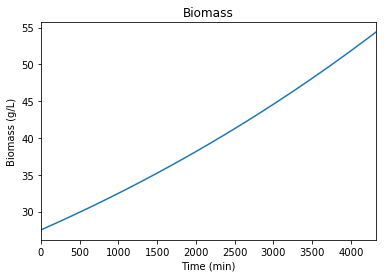

In [15]:
ax_val = plt.axes()
ax_val.set_xlabel('Time (min)')
ax_val.set_ylabel('Biomass (g/L)')
biomass.loc['Biomass',:].plot(ax=ax_val,title='Biomass')

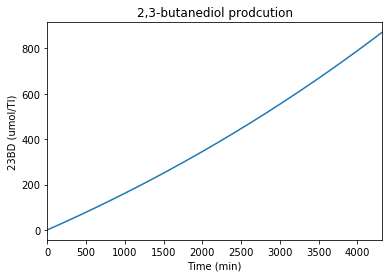

In [16]:
ax_val = plt.axes()
ax_val.set_xlabel('Time (min)')
ax_val.set_ylabel('23BD (umol/TI)')
biomass.loc['23BD',:].plot(ax=ax_val,title='2,3-butanediol prodcution')

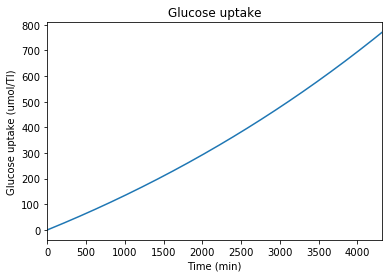

In [17]:
ax_val = plt.axes()
ax_val.set_xlabel('Time (min)')
ax_val.set_ylabel('Glucose uptake (umol/TI)')
biomass.loc['glucose',:].plot(ax=ax_val,title='Glucose uptake')